
# Evidencia de aprendizaje 2: procesamiento de datos en una infraestructura cloud

 * **Trabajo realizado por: Juan David Ramírez García**
 * **Docente: Andres Felipe Callejas Jaramillo**
 * **Universidad: IUDigital del Antioquia**

## 1. Diseño de esquema

**Descripción del esquema** 

A continuación, se describe el esquema de almacenamiento diseñado para gestionar los datos de la **FundaciónVida**. Esta arquitectura centraliza la información de las diversas investigaciones oncológicas realizadas por la organización, con el objetivo de encontrar el mejor tratamiento contra el cáncer y mejorar la calidad de vida de los pacientes que hacen parte del estudio. La estructura se basa en una jerarquía de tres niveles que permite organizar las distintas cohortes de estudio de manera eficiente y escalable.


**Jerarquía y arquitectura**

- **1. Metastore** Fundacionvida: es el contenedor principal que contiene toda la gestión de datos de la fundación.

- **2. Catálogo** Estudios oncologicos: es el espacio que contiene todas las iniciativas de investigación y estudios relacionados con el cáncer, separándolos de otras áreas operativas o financieras. En este se crean los esquemas que alamacenan los datos de los diferentes actividades de las investigaciones.

- **3. Esquemas**:

   * PacientesCancerPulmon: Esquema activo que contiene las tablas y datos específicos para el estudio actual de cáncer de pulmón. Este contiene las tablas pacientas y historial.

   * PacientesCancerProstata: Esquema vació el cual hace parte del estudio futuro de la fundación.

**Detalles de las entidades y relaciones claves**

   El esquema **PacientesCancerPulmon** contiene la información del estudio actual comformado por dos tablas relacionales: 

   - Tabla Pacientes: Almacena la información personal y estática de los participantes. Sus campos 
   clave incluyen:
      - Identificación y demografía: id, age (edad), gender (género), country (país).
      -  Factores de riesgo: family_history (antecedentes familiares), smoking_status (estado de fumador) y bmi (índice de masa corporal).
        
   - Tabla Historial: Registra los eventos médicos y la evolución de la enfermedad. Sus campos clave incluyen:
     - Diagnóstico: diagnosis_date, cancer_stage (etapa).
     - Comorbilidades y métricas: cholesterol_level, hypertension, asthma, cirrhosis, other_cancer.- Tratamiento y desenlace: treatment_type, end_treatment_date, survived.

**Relaciones entre las tablas**

Existe una relación **uno a uno** entre ambas entidades. Las tablas están vinculadas mediante el campo **id** que es la **clave primaria** de **Pacientes** y **patient_id** que es clave **Foránea** en la tabla **Historial**, lo que permite integrar los perfiles demográficos con sus respectivos historiales clínicos para un análisis de datos más adelante.



### Gráfico y arquitectura del esquema

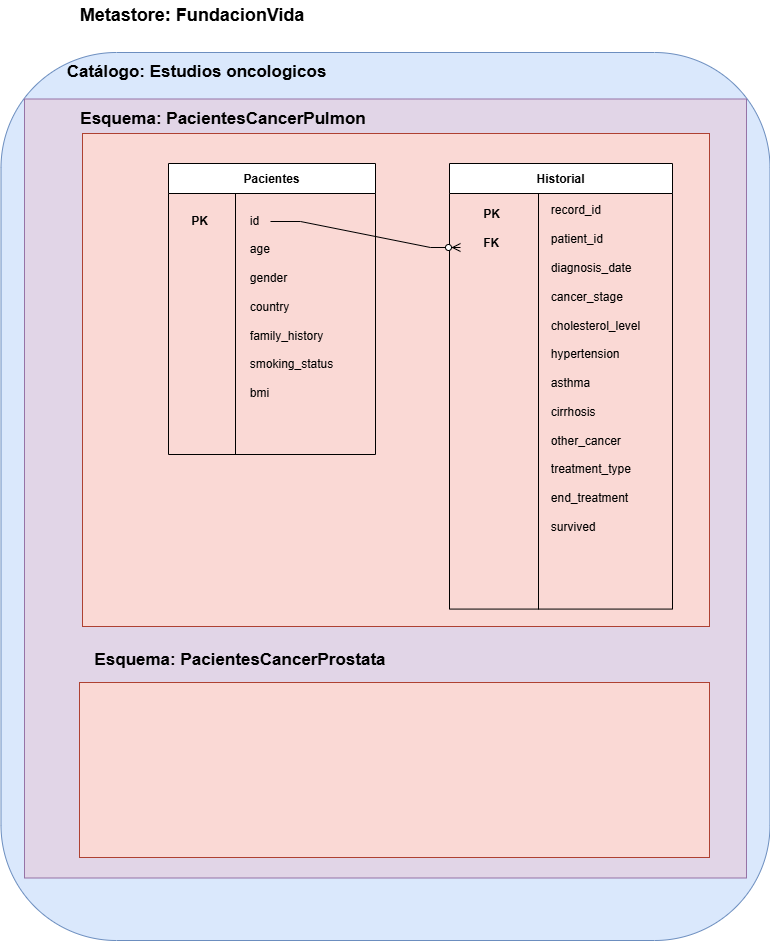

In [1]:
from IPython.display import Image

# Use the path to the new PNG file you just created
image_path = "/workspaces/Bigdata_2025-2/docs/esquema.drawio.png"


# This will display the diagram directly in the cell's output
Image(filename=image_path)

## 2. Configura y evidencia

#### Paso a paso para crear un sevidor: 
1. Primero, vamos a la parte izquierda de la interfaz. En el menú de navegación, damos clic en el icono de `Compute` Cómputo, que generalmente tiene un icono de una nube.
2. Una vez en la página de Cómputo, busca y haz clic en el botón azul o naranja que dice `+ Create Compute` (Crear Cómputo).
3. En el formulario que te aprecerá, en el campo `Cluster Name` (Nombre del Cluster), escribe un nombre fácil de recordar para tu servidor, por ejemplo: `miprimerservidor`
4. Después seleccionamos la version, revisamos la sección "Databricks Runtime Version" (Versión de Runtime). Nos aseguramos de seleccionar una versión reciente, preferiblemente la `LTS` (Long Term Support) disponible. Las demás opciones de tamaño de Worker están predefinidas y no se pueden cambiar en la Community Edition.
5. finalizamos creando el servidor o cluster, le damos clic en el botón `Create cluster` en la parte inferior de la pantalla.
6. Por último esperamos que el servidor se inicialice. Cuando vea el estado **Running** con un circulo verde el servidor esta listo para utlizarse.

**Nota:** el servidor se apagará automáticamente después de un tiempo de inactividad de más o menos 120 minutos para ahorrar recursos. Esto es normal en la edición gratuita y no tienes que borrarlo manualmente.

**Referencia:** en este video de YouTube hay un ejemplo práctico de como crear un servidor
https://youtu.be/FMwpleETVKg?si=gYg4rClbaErtmX9x



## 3. Obtención de datos y creación de tablas

 1. Creación del catalogo estudios_oncologicos

In [0]:
%sql
CREATE CATALOG IF NOT EXISTS estudios_oncologicos;

2. Creación del esquema pacientesCancerPulmon.
Se usa `USE CATALOG` para que cree el esquema dentro del catalogo `estudios_oncologicos`

In [0]:
%sql
USE CATALOG estudios_oncologicos;

CREATE SCHEMA IF NOT EXISTS pacientesCancerPulmon;

3. Creamos una tabla staging para guardar los datos en crudo llamada `lung_cancer_staging`, la cual nos va permitir almacenar los datos y organizarlos antes de llevarlos a las dos tablas finales `pacientes` y `historial`

In [0]:
%sql

USE SCHEMA pacientescancerpulmon;

create or replace table lung_cancer_staging(
  id string,
  age string,
  gender string,
  country string,
  diagnosis_date string,
  cancer_stage string,
  family_history string,
  smoking_status string,
  bmi string,
  cholesterol_level string,
  hypertension string,
  asthma string,
  cirrhosis string,
  other_cancer string,
  treatment_type string,
  end_treatment_date string,
  survived string
)using delta;

4. Ingesta de los datos en la tabla `lung_cancer_staging` desde el conjunto de datos descargado desde Kaggle y guardado como `Lung_cancer.csv`.

Enlace para descargar el dataset: https://www.kaggle.com/datasets/khwaishsaxena/lung-cancer-dataset/data

In [0]:
%sql
COPY INTO lung_cancer_staging
FROM '/Volumes/workspace/bigdata_2025_2/lung_cancer/Lung _cancer.csv'
FILEFORMAT = CSV
FORMAT_OPTIONS (
  'header' = 'true',      -- El CSV tiene encabezados
  'delimiter' = ',',      -- El separador es una coma
  'inferSchema' = 'false' -- No queremos inferir, ya definimos la tabla
);

num_affected_rows,num_inserted_rows,num_skipped_corrupt_files
890000,890000,0


5. Creación e ingestados de datos de las tablas `pacientes` e `historial`en el esquema `pacientescancerpulmon`

In [0]:
%sql

USE SCHEMA pacientescancerpulmon;

-- Crear tabla pacientes
CREATE OR REPLACE TABLE pacientes AS
SELECT DISTINCT
  CAST(id AS INT) AS id, -- se usa CAST para convertir el id a INT
  TRY_CAST(age AS INT) AS age, -- se usa TRY_CAST para convertir el age a INT
  CAST(gender AS STRING) AS gender, -- se usa CAST para convertir el gender a STRING
  CAST(country AS STRING) AS country, -- ...
  CAST(family_history AS BOOLEAN) AS family_history,-- ...
  CAST(smoking_status AS STRING) AS smoking_status,-- ...
  CAST(cirrhosis AS BOOLEAN) AS cirrhosis,-- ...
  CAST(other_cancer AS BOOLEAN) AS other_cancer,
  CAST(bmi AS DOUBLE) AS bmi
FROM
  lung_cancer_staging;

-- crear tabla historial
CREATE OR REPLACE TABLE historial AS
SELECT
  CAST(id AS INT) AS patient_id,
  CAST(diagnosis_date AS DATE) AS diagnosis_date,
  CAST(cancer_stage AS STRING) AS cancer_stage,
  CAST(cholesterol_level AS INT) AS cholesterol_level,
  CAST(hypertension AS BOOLEAN) AS hypertension,
  CAST(asthma AS BOOLEAN) AS asthma,
  CAST(survived AS BOOLEAN) AS survived
FROM
   lung_cancer_staging;

num_affected_rows,num_inserted_rows


6. Se usa `describe table` para corroborar que los datos fueron cargados correctamente en las tablas creadas. Esta ejecución nos trae el nombre de las columnas con sus respectivos tipos de datos.

In [0]:
%sql
describe table pacientes;

col_name,data_type,comment
id,int,null
age,int,null
gender,string,null
country,string,null
family_history,boolean,null
smoking_status,string,null
cirrhosis,boolean,null
other_cancer,boolean,null
bmi,double,null


In [0]:
%sql
describe table historial;

col_name,data_type,comment
patient_id,int,null
diagnosis_date,date,null
cancer_stage,string,null
cholesterol_level,int,null
hypertension,boolean,null
asthma,boolean,null
survived,boolean,null


## 4. Validaciones Spark y SQL

1. **Metadatos y descripción de datos**

Con la sentencia `SHOW CREATE TABLE` se muestra la información completa sobre cómo fue creada una tabla, incluyendo las instrucciones SQL y propiedades utilizadas para definir su estructura dentro del esquema de datos.

En nuestro caso, para la tabla **pacientes** el resultado obtenido fue el siguiente:

`CREATE TABLE estudios_oncologicos.pacientescancerpulmon.pacientes (
  id INT,
  age INT,
  gender STRING,
  country STRING,
  family_history BOOLEAN,
  smoking_status STRING,
  bmi DOUBLE
)
USING delta
COLLATION 'UTF8_BINARY'
TBLPROPERTIES (
  'delta.enableDeletionVectors' = 'true',
  'delta.feature.appendOnly' = 'supported',
  'delta.feature.deletionVectors' = 'supported',
  'delta.feature.invariants' = 'supported',
  'delta.minReaderVersion' = '3',
  'delta.minWriterVersion' = '7'
)
`

In [0]:
%sql
show create table pacientes;

createtab_stmt
"CREATE TABLE estudios_oncologicos.pacientescancerpulmon.pacientes ( id INT, age INT, gender STRING, country STRING, family_history BOOLEAN, smoking_status STRING, cirrhosis BOOLEAN, other_cancer BOOLEAN, bmi DOUBLE) USING delta COLLATION 'UTF8_BINARY' TBLPROPERTIES ( 'delta.enableDeletionVectors' = 'true', 'delta.feature.appendOnly' = 'supported', 'delta.feature.deletionVectors' = 'supported', 'delta.feature.invariants' = 'supported', 'delta.minReaderVersion' = '3', 'delta.minWriterVersion' = '7', 'delta.parquet.compression.codec' = 'zstd')"


Para el caso de la tabla **historial**, el resultado fue: 

`CREATE TABLE estudios_oncologicos.pacientescancerpulmon.historial ( patient_id INT, diagnosis_date DATE, cancer_stage STRING, cholesterol_level INT, hypertension BOOLEAN, asthma BOOLEAN, survived BOOLEAN) USING delta COLLATION 'UTF8_BINARY' TBLPROPERTIES ( 'delta.enableDeletionVectors' = 'true', 'delta.feature.appendOnly' = 'supported', 'delta.feature.deletionVectors' = 'supported', 'delta.feature.invariants' = 'supported', 'delta.minReaderVersion' = '3', 'delta.minWriterVersion' = '7')`

In [0]:
%sql
show create table historial;

createtab_stmt
"CREATE TABLE estudios_oncologicos.pacientescancerpulmon.historial ( patient_id INT, diagnosis_date DATE, cancer_stage STRING, cholesterol_level INT, hypertension BOOLEAN, asthma BOOLEAN, survived BOOLEAN) USING delta COLLATION 'UTF8_BINARY' TBLPROPERTIES ( 'delta.enableDeletionVectors' = 'true', 'delta.feature.appendOnly' = 'supported', 'delta.feature.deletionVectors' = 'supported', 'delta.feature.invariants' = 'supported', 'delta.minReaderVersion' = '3', 'delta.minWriterVersion' = '7', 'delta.parquet.compression.codec' = 'zstd')"


2. **Conteo y primeras vistas**

Este query muestra las primeras 10 filas de todos los campos de la tabla `pacientes`

In [0]:
%sql
SELECT *
FROM pacientes
LIMIT 10; -- Numero de registros

id,age,gender,country,family_history,smoking_status,cirrhosis,other_cancer,bmi
2795,null,Female,Estonia,false,Never Smoked,false,false,17.9
3625,null,Male,Finland,false,Passive Smoker,false,false,18.9
4874,null,Female,Spain,false,Current Smoker,false,false,24.3
5905,null,Female,Bulgaria,false,Passive Smoker,false,false,34.6
10228,null,Female,Slovakia,false,Never Smoked,false,false,24.1
13210,null,Male,Finland,false,Passive Smoker,false,false,21.2
14149,null,Male,Czech Republic,true,Never Smoked,false,false,38.0
15474,null,Male,Italy,false,Current Smoker,true,false,20.8
16033,null,Female,Sweden,false,Never Smoked,true,false,40.5
16315,null,Female,Bulgaria,true,Passive Smoker,true,false,26.1


con la sentencia `count(*)` verficamos el número de datos o regeistros que tiene nuestra tabla pacientes.

In [0]:
%sql
select count(*) from pacientes;
    
    


count(*)
890000


Podemos apreciar que la tabla pacientes tiene **890000** datos

De igual forma msotramos los primeros 10 filas de nuestra tabla `historial`.

In [0]:
%sql
SELECT *
FROM historial
LIMIT 10; -- se limita a 10 registros

patient_id,diagnosis_date,cancer_stage,cholesterol_level,hypertension,asthma,survived
1,2016-04-05,Stage I,199,false,false,false
2,2023-04-20,Stage III,280,true,true,true
3,2023-04-05,Stage III,268,true,true,false
4,2016-02-05,Stage I,241,true,true,false
5,2023-11-29,Stage I,178,false,false,false
6,2023-01-02,Stage I,274,true,false,false
7,2018-05-21,Stage III,259,false,false,true
8,2017-02-18,Stage IV,195,true,true,false
9,2021-03-21,Stage III,236,false,false,false
10,2021-11-30,Stage IV,183,true,false,false


Contemos el número de datos de la tabla `historial`

In [0]:
%sql
select count(*) from historial; -- Numero de registros

count(*)
890000


3. **Consultas SELECT y GROUP BY**

**Distribución de las etapas del cancer :**
Con las sentencias `ORDER BY` y `GROUP BY` vamos a mostrar el porcentaje de pacientes por la etapa que se encuentra del cancer, usando el siguiente cálculo `ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM historial), 2)`

In [0]:
%sql
SELECT
    cancer_stage,
    COUNT(*) AS total_pacientes,
    ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM historial), 2) AS porcentaje -- Se calcula el porcentaje
FROM historial
GROUP BY cancer_stage -- Se agrupan por etapa
ORDER BY total_pacientes DESC; -- Se ordenan por total

cancer_stage,total_pacientes,porcentaje
Stage III,222594,25.01
Stage IV,222527,25.00
Stage I,222516,25.00
Stage II,222363,24.98


**Del siguiente resultado podemos destacar :**
- que la distribución de pacientes por cada una las fases del cancer es casi igual, todas con un **25%**. 

**Estado de supervivencia de pacientes por país :**
Vamos a mirar los **5** países con más número de pacientes con estado sobrevivientes, es decir para `survived=true`


In [0]:
%sql
SELECT
    p.country,
    h.survived,
    COUNT(*) AS total
FROM pacientes as p
JOIN historial as h ON p.id=h.patient_id -- Se relacionan las tablas
WHERE survived=true -- Se filtra los pacientes vivos
GROUP BY country, survived -- Se agrupan por pais y estado
ORDER BY total DESC    -- Se ordenan por total
LIMIT 5;    -- Se limita a los 5 primeros

country,survived,total
Malta,true,7426
Portugal,true,7372
Netherlands,true,7355
Estonia,true,7339
Czech Republic,true,7331


Los paises con más pacientes en estado sobreviente son: **Malta, Portugal, the Netherlands, Estonia y Czech Republic.**

## 5. Ventajas y desventajas: SQL vs SPARK

## Tabla Comparativa

| Propósito | SQL  | Propósito | Spark |
|----------------------------|----------------------|-----------------------------|----------------------------------|
| Facilidad de uso           | SQL es más fácil de usar porque todo es declarativo y directo; y tiene una lógica más sencilla. | Escalabilidad          |Noto que spark tiene una mayor capacidad para trabajar con grandes volúmenes de datos distribuidos. |
| Expresividad declarativa   | Me parece que SQL permite expresar consultas complejas con pocas líneas y la sintaxis es más sencilla. | APIs ricas (DataFrame/RDD)       |  Spark es muy versatil gen cuanto a sus APIs, que permiten transformaciones avanzadas. |
| Integración con BI         | Considero que SQL se integra mucho mejor con herramientas de BI tradicionales. | UDFs y funciones personalizadas  | Siento que Spark facilita mucho más el uso de UDFs en Python para lógica compleja. |
| Limitaciones en pipelines  | En mi experiencia, SQL se queda corto cuando necesito pipelines muy complejos. | MLlib                            | Veo que Spark es una herramienta fuerta para el trabajo con modelos de ML, en cambio SQL su fuerte es la organizar información de manera lógica. |
| Limitaciones con UDFs      | Percibo que las UDFs en SQL dependen demasiado del motor y pueden ser restrictivas. | Curva de aprendizaje y tuning    | creo que la curva de aprendizaje en spark es mucho mpás inclinada por las multiples funcionalidades e intregraciones que la herrmaiente posee. |
